In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import xml.etree.ElementTree as ET
from lxml import etree

In [3]:
run -im djd.main -- --dbname=dj_lisa --r

For remote access to work, make sure to first open an SSH tunnel with MySQL
port forwarding. Run the `djdtunnel` script in a separate terminal, with
optional `--user` argument if your local and remote user names differ.
Or, open the tunnel manually with:
  ssh -NL 3306:huxley.neuro.bzm:3306 -p 1021 USERNAME@tunnel.bio.lmu.de
Connecting write@localhost:3306
Connected to database 'dj_lisa' as 'write@10.153.172.3'
For remote file access to work, make sure to first mount the filesystem at tunnel.bio.lmu.de:1021 via SSH


In [4]:
run -i /gpfs01/berens/user/lschmors/Code/dLGN_project/djd/djd/signal.py

In [5]:
run -i /gpfs01/berens/user/lschmors/Code/dLGN_project/djd/djd/util.py

In [27]:
key = {'m':'Ntsr1Cre_2019_0004', 's':2, 'e':4} # one example experiment with hmov stimulus

### Get trigger times for frames

In [28]:
dwordts = get_nev_times(key)

### Get photodiode rise and fall times

In [29]:
rise, fall = get_nsx_risefalltimes(key, chan='photodiode')

/gpfs01/berens/user/lschmors/mudata/exp/Ntsr1Cre_2019_0004/s02/Ntsr1Cre_2019_0004_s02_e04.ns3


In [30]:
sortedrisefall = np.sort(np.hstack([rise, fall]))

#### Select dwordts that are within hmov tranges

In [31]:
dwordts_hmov = dwordts[np.where((dwordts>rise[0]) & (dwordts<fall[-1]))]
print(dwordts_hmov.shape[0])
print(len(sortedrisefall))

108000
107998


-> two frames have been dropped

Where did the drop happen?

Text(0, 0.5, 'interval of rise/fall times [s]')

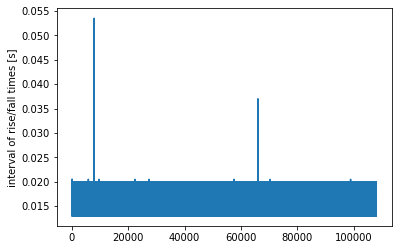

In [32]:
plt.plot(np.diff(sortedrisefall))
plt.ylabel('interval of rise/fall times [s]')

The fluctuations in the photodiode signal (betw. ~0.014 s and ~0.02 s) probably come from a different sensitivity to LCD switching from white to black and vice versa. The two long intervals are the frame drops.

But digital words sent out is also fluctuating:

Text(0, 0.5, 'interval of dwords time stamps [s]')

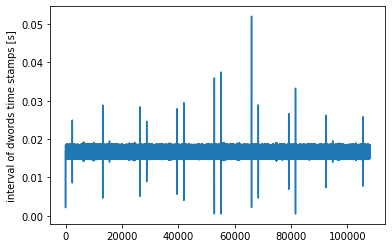

In [33]:
plt.plot(np.diff(dwordts_hmov))
plt.ylabel('interval of dwords time stamps [s]')

Text(0.5, 0, 'ts intervals for dword send out')

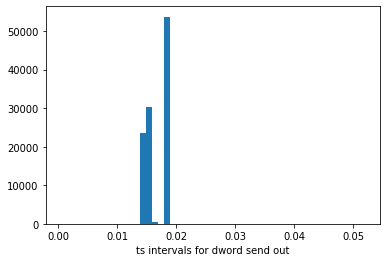

In [34]:
plt.hist(np.diff(dwordts_hmov),50)
plt.xlabel('ts intervals for dword send out')

Where does this fluctuations come from?

### Get the delay between rise/fall times and digital word time stamp

Fluctuations will affect the calculated delay (difference)

Text(0.5, 1.0, 'diff. betw. photodiode rise/fall time and time stamp of dword send out')

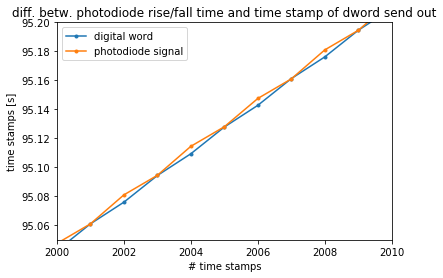

In [35]:
plt.plot(dwordts_hmov, marker='.', label='digital word')
plt.plot(sortedrisefall, marker='.', label='photodiode signal')
plt.xlim((2000,2010))
plt.ylim(95.05,95.2)
plt.legend()
plt.ylabel('time stamps [s]')
plt.xlabel('# time stamps')
plt.title('diff. betw. photodiode rise/fall time and time stamp of dword send out')

Compute the delay for all time stamps:

In [36]:
delay = sortedrisefall - dwordts_hmov[:-2] # account for the 2 frames that have been dropped

Text(0, 0.5, 'delay [s]')

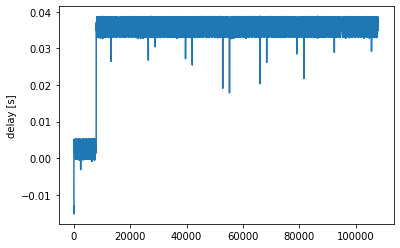

In [37]:
plt.plot(delay)
plt.ylabel('delay [s]')

Step is due to frame drop:

In [54]:
delay[7908:7912]

array([0.00336667, 0.00193333, 0.037     , 0.03503333])

Step is between `delay[7909]` and `delay[7910]`

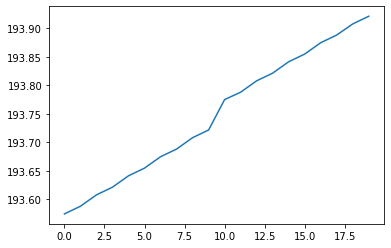

In [59]:
plt.plot(sortedrisefall[7900:7920])

-> delay increases with after frame drop -> delay will be biased

#### Histogram of delays between rise/fall times and time stamps of digital word sent out:

Text(0.5, 0, 'delay [s]')

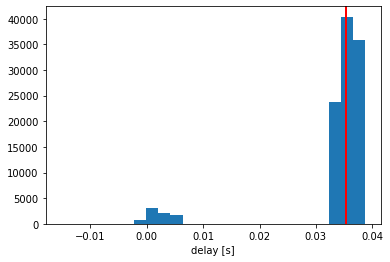

In [38]:
plt.hist(delay, 25)
plt.axvline(x=np.median(delay), linewidth=2, color='r')
plt.xlabel('delay [s]')

The median is taken to get one value that is representative for the offset between digital word that is send out to the monitor and the actually shown frame:

In [39]:
deltat = np.median(sortedrisefall - dwordts_hmov[:-2])

The ``deltat`` is returned as the offset. However this large offset only appears due to the frame drop (rise times are ahead of digital word time stamps). This is only happens if ``dwordts_hmov[:-num_dropped_frames]`` is used to compute the delay.

-> better alternative to account for a frame drop? (e.g., only compute the delay in a in a time range where no frame was dropped?)